<a href="https://colab.research.google.com/github/AntoninaRemizova/ML/blob/main/ML_class_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install scikit-image

In [2]:
!pip install scikit-image opencv-python seaborn pandas numpy matplotlib scikit-learn

# Импорт

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from skimage.feature import hog
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb
from skimage import exposure

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, accuracy_score,
                            precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import joblib
import cv2
from glob import glob
import zipfile
import io
from PIL import Image

np.random.seed(42)

In [4]:
!wget -q https://github.com/AntoninaRemizova/ML/archive/refs/heads/main.zip

In [5]:
os.makedirs('/content/data/tiger', exist_ok=True)
os.makedirs('/content/data/zebra', exist_ok=True)

In [6]:
with zipfile.ZipFile('main.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ml_data')
import shutil

tiger_files = glob('/content/ml_data/ML-main/tiger/*.jpg') + glob('/content/ml_data/ML-main/tiger/*.jpeg') + glob('/content/ml_data/ML-main/tiger/*.png')
for i, file_path in enumerate(tiger_files[:100]):
    shutil.copy(file_path, f'/content/data/tiger/tiger_{i:03d}.jpg')

zebra_files = glob('/content/ml_data/ML-main/zebra/*.jpg') + glob('/content/ml_data/ML-main/zebra/*.jpeg') + glob('/content/ml_data/ML-main/zebra/*.png')
for i, file_path in enumerate(zebra_files[:100]):
    shutil.copy(file_path, f'/content/data/zebra/zebra_{i:03d}.jpg')

tiger_files = glob('/content/data/tiger/*.jpg') + glob('/content/data/tiger/*.jpeg') + glob('/content/data/tiger/*.png')
zebra_files = glob('/content/data/zebra/*.jpg') + glob('/content/data/zebra/*.jpeg') + glob('/content/data/zebra/*.png')

print(f"  Тигры: {len(tiger_files)}")
print(f"  Зебры: {len(zebra_files)}")

  Тигры: 100
  Зебры: 100


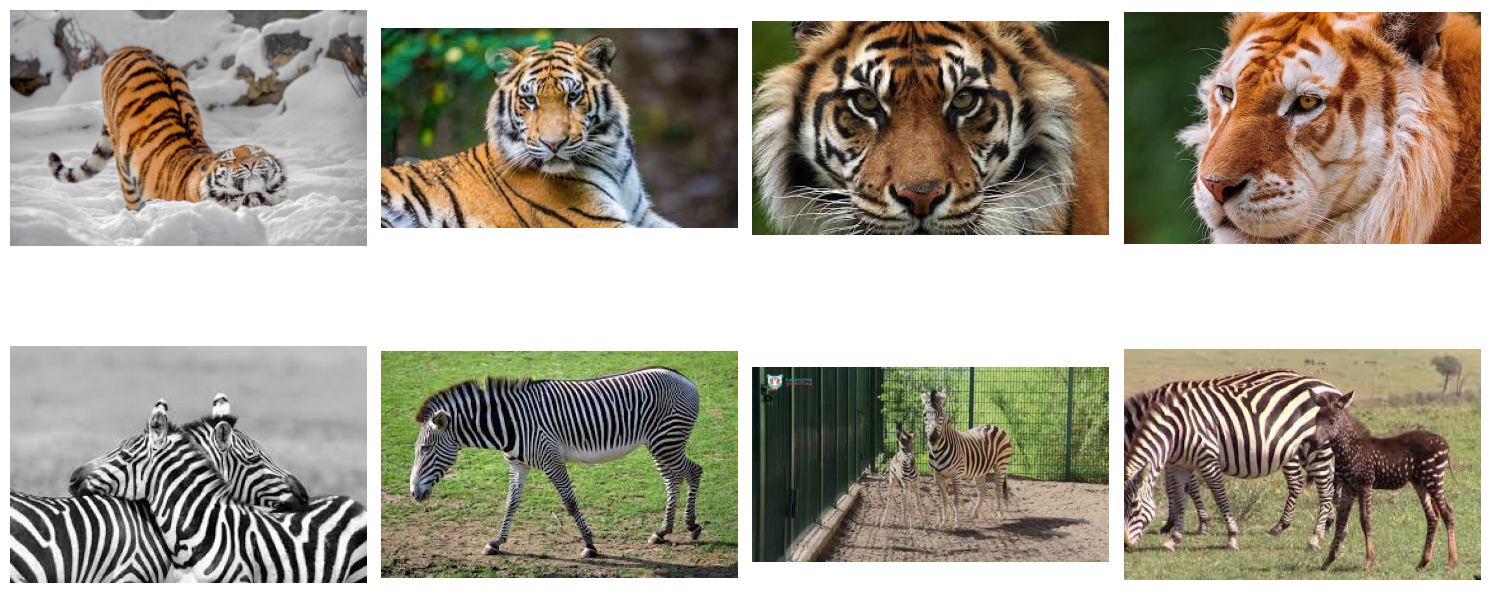

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i in range(4):
    if i < len(tiger_files):
        img = imread(tiger_files[i])
        axes[0, i].imshow(img)
        axes[0, i].axis('off')

for i in range(4):
    if i < len(zebra_files):
        img = imread(zebra_files[i])
        axes[1, i].imshow(img)
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# HOG

In [8]:
def extract_hog_features(image_path, target_size=(128, 128),
                        orientations=9, pixels_per_cell=(16, 16),
                        cells_per_block=(2, 2), visualize=False):
    try:
        img = imread(image_path)

        if img.shape[-1] == 4:
            img = img[:, :, :3]

        if len(img.shape) == 3 and img.shape[-1] == 3:
            gray_img = rgb2gray(img)
        else:
            gray_img = img

        resized_img = resize(gray_img, target_size, anti_aliasing=True)
        resized_img = exposure.equalize_adapthist(resized_img, clip_limit=0.03)

        if visualize:
            features, hog_image = hog(
                resized_img,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                visualize=True,
                block_norm='L2-Hys',
                feature_vector=True
            )
            return features, hog_image, resized_img
        else:
            features = hog(
                resized_img,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                visualize=False,
                block_norm='L2-Hys',
                feature_vector=True
            )
            return features, None, resized_img

    except Exception as e:
        print(f"Ошибка {image_path}: {e}")
        return None, None, None

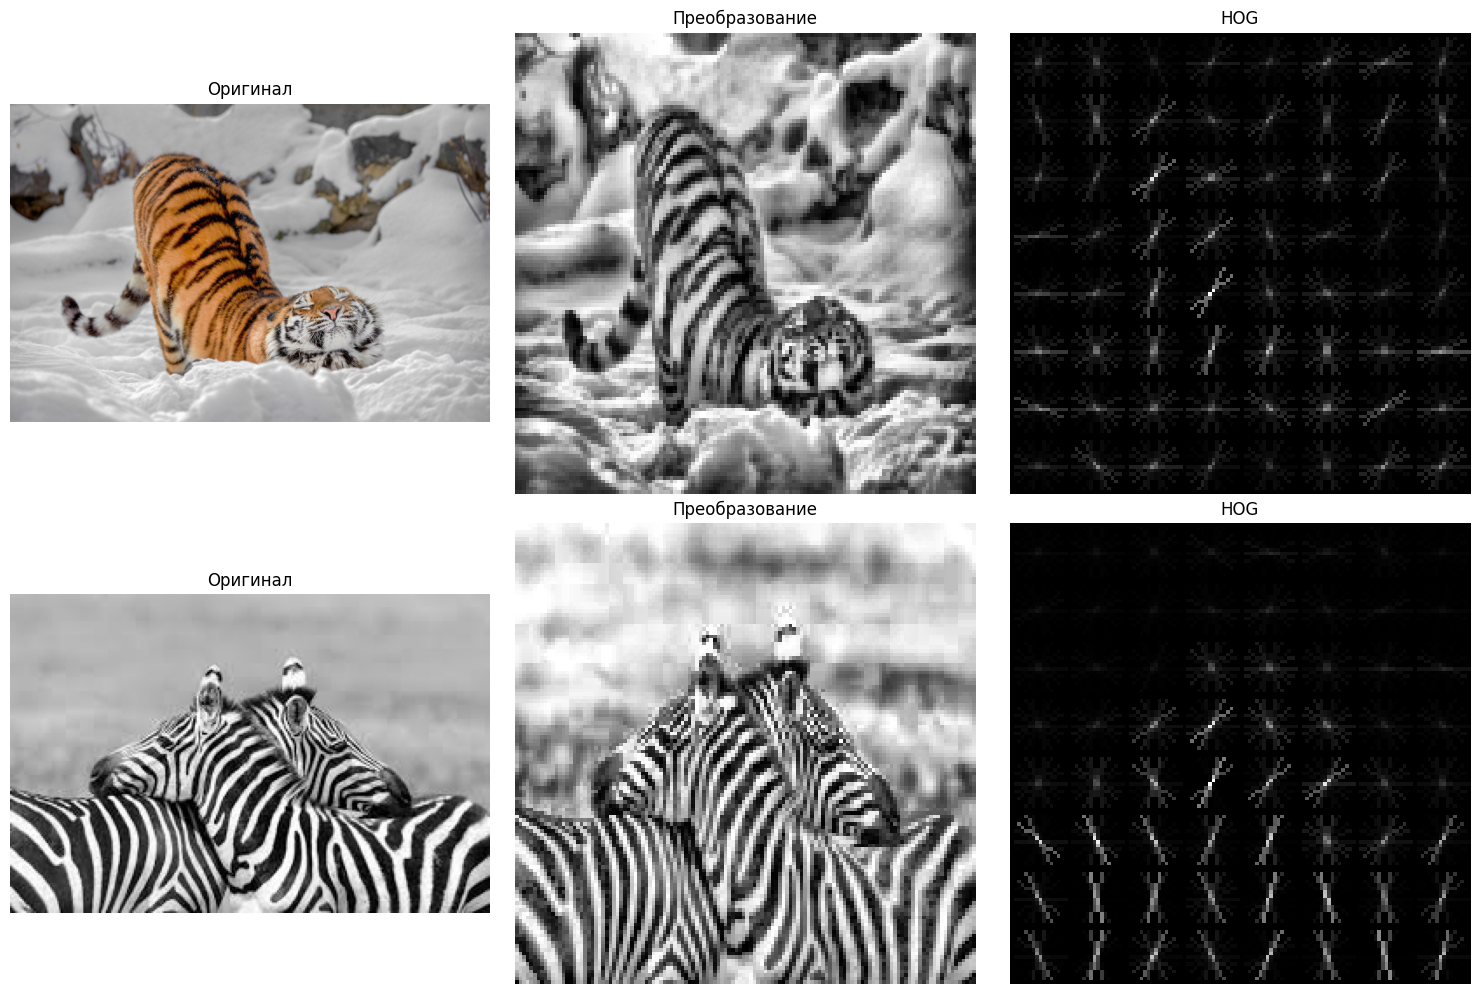

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

if len(tiger_files) > 0:
    hog_features_tiger, hog_image_tiger, processed_tiger = extract_hog_features(
        tiger_files[0], visualize=True
    )

    axes[0, 0].imshow(imread(tiger_files[0]))
    axes[0, 0].set_title('Оригинал')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(processed_tiger, cmap='gray')
    axes[0, 1].set_title('Преобразование')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(hog_image_tiger, cmap='gray')
    axes[0, 2].set_title('HOG')
    axes[0, 2].axis('off')

if len(zebra_files) > 0:
    hog_features_zebra, hog_image_zebra, processed_zebra = extract_hog_features(
        zebra_files[0], visualize=True
    )

    axes[1, 0].imshow(imread(zebra_files[0]))
    axes[1, 0].set_title('Оригинал')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(processed_zebra, cmap='gray')
    axes[1, 1].set_title('Преобразование')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(hog_image_zebra, cmap='gray')
    axes[1, 2].set_title('HOG')
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [10]:
data = []
labels = []
filenames = []
failed_images = []

# класс 1 - тигр
for img_path in tqdm(tiger_files[:100]):
    features, _, _ = extract_hog_features(img_path, visualize=False)
    if features is not None:
        data.append(features)
        labels.append(1)
        filenames.append(os.path.basename(img_path))
    else:
        failed_images.append(img_path)

# класс 0 - зебра
for img_path in tqdm(zebra_files[:100]):
    features, _, _ = extract_hog_features(img_path, visualize=False)
    if features is not None:
        data.append(features)
        labels.append(0)
        filenames.append(os.path.basename(img_path))
    else:
        failed_images.append(img_path)

print(f"\nУспешно обработано: {len(data)} изображений")
print(f"Не удалось обработать: {len(failed_images)} изображений")
if failed_images:
    print("Проблемные файлы:", failed_images[:5])


100%|██████████| 100/100 [00:19<00:00,  5.20it/s]



Успешно обработано: 200 изображений
Не удалось обработать: 0 изображений


In [11]:
df = pd.DataFrame(data)
df['filename'] = filenames
df['label'] = labels
df['class_name'] = df['label'].map({1: 'tiger', 0: 'zebra'})

In [12]:
df

0         1         2         3         4         5         6  \
0    0.223018  0.144410  0.210089  0.119860  0.170126  0.090964  0.159338   
1    0.239465  0.239465  0.239465  0.146716  0.132957  0.053752  0.031234   
2    0.162433  0.064107  0.134177  0.065287  0.058968  0.045878  0.098965   
3    0.225059  0.211870  0.225059  0.225059  0.135939  0.225059  0.158384   
4    0.144650  0.133073  0.138958  0.198198  0.226399  0.101212  0.090067   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.211168  0.190050  0.194852  0.096181  0.211168  0.179422  0.174446   
196  0.210027  0.141090  0.150943  0.066948  0.210027  0.210027  0.205592   
197  0.106259  0.057921  0.037749  0.106599  0.114791  0.074641  0.088252   
198  0.131080  0.054698  0.052389  0.067062  0.196387  0.132977  0.104617   
199  0.107432  0.194739  0.187485  0.154243  0.216438  0.073354  0.074523   

            7         8         9  ...      1757      1758      1759  \
0    0.107029  0.172584  0.205027  ...  0.254595  0.254595  0.227320   
1    0.056559  0.120403  0.239465  ...  0.141142  0.093973  0.099842   
2    0.158018  0.114637  0.270461  ...  0.062786  0.039509  0.070747   
3    0.134431  0.115654  0.158499  ...  0.186358  0.141939  0.104264   
4    0.241964  0.129270  0.241964  ...  0.030326  0.035530  0.110468   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.120687  0.185953  0.211168  ...  0.220599  0.220599  0.209504   
196  0.210027  0.178035  0.161904  ...  0.187924  0.127430  0.184715   
197  0.214451  0.142776  0.254419  ...  0.273978  0.219989  0.124359   
198  0.044800  0.069377  0.112895  ...  0.156305  0.141091  0.204155   
199  0.046210  0.033149  0.141496  ...  0.186596  0.133235  0.178746   

         1760      1761      1762      1763       filename  label  class_name  
0    0.111902  0.054184  0.081556  0.083991  tiger_091.jpg      1       tiger  
1    0.071093  0.078676  0.094070  0.191741  tiger_078.jpg      1       tiger  
2    0.040517  0.084786  0.076448  0.229787  tiger_097.jpg      1       tiger  
3    0.075276  0.051233  0.115735  0.105884  tiger_013.jpg      1       tiger  
4    0.074150  0.196621  0.259505  0.259505  tiger_035.jpg      1       tiger  
..        ...       ...       ...       ...            ...    ...         ...  
195  0.188117  0.179202  0.139561  0.115546  zebra_017.jpg      0       zebra  
196  0.103995  0.108267  0.123450  0.156887  zebra_026.jpg      0       zebra  
197  0.066169  0.026441  0.130473  0.209525  zebra_050.jpg      0       zebra  
198  0.155134  0.171548  0.119742  0.168534  zebra_020.jpg      0       zebra  
199  0.147800  0.116949  0.087191  0.050566  zebra_025.jpg      0       zebra  

[200 rows x 1767 columns]

# обучение моделей

In [13]:
X = df.drop(['filename', 'label', 'class_name'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_indices = X_train.index
test_indices = X_test.index

train_filenames = df.loc[train_indices, 'filename'].values
test_filenames = df.loc[test_indices, 'filename'].values
train_labels = df.loc[train_indices, 'label'].values
test_labels = df.loc[test_indices, 'label'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_save = X_test.copy()
X_test_save['filename'] = test_filenames
X_test_save['true_label'] = y_test.values

In [14]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, C=1.0, gamma='scale'),

}

results = {}
predictions = {}
probabilities = {}


In [29]:
y_pred_lr = None
y_pred_rf = None
y_pred_svm = None

y_test_lr = None
y_test_rf = None
y_test_svm = None

In [30]:
for name, model in tqdm(models.items()):
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'cv_mean': cv_scores.mean(),
    }

    if name == 'Logistic Regression':
        y_pred_lr = y_pred
        y_test_lr = y_test.values
    elif name == 'Random Forest':
        y_pred_rf = y_pred
        y_test_rf = y_test.values
    elif name == 'SVM':
        y_pred_svm = y_pred
        y_test_svm = y_test.values

    predictions[name] = y_pred
    if y_proba is not None:
        probabilities[name] = y_proba


100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


In [16]:
results_df = pd.DataFrame([
    {
        'Model': name,
        'AUC-ROC': res['auc'] if res['auc'] else np.nan,
        'Accuracy': res['accuracy'],
        'CV Accuracy': res['cv_mean'],
    }
    for name, res in results.items()
]).sort_values('AUC-ROC', ascending=False)

print(results_df.to_string(index=False))

              Model  AUC-ROC  Accuracy  CV Accuracy
                SVM  0.94750       0.9      0.81250
      Random Forest  0.93875       0.9      0.83125
Logistic Regression  0.88750       0.8      0.83125


# ROC AUC

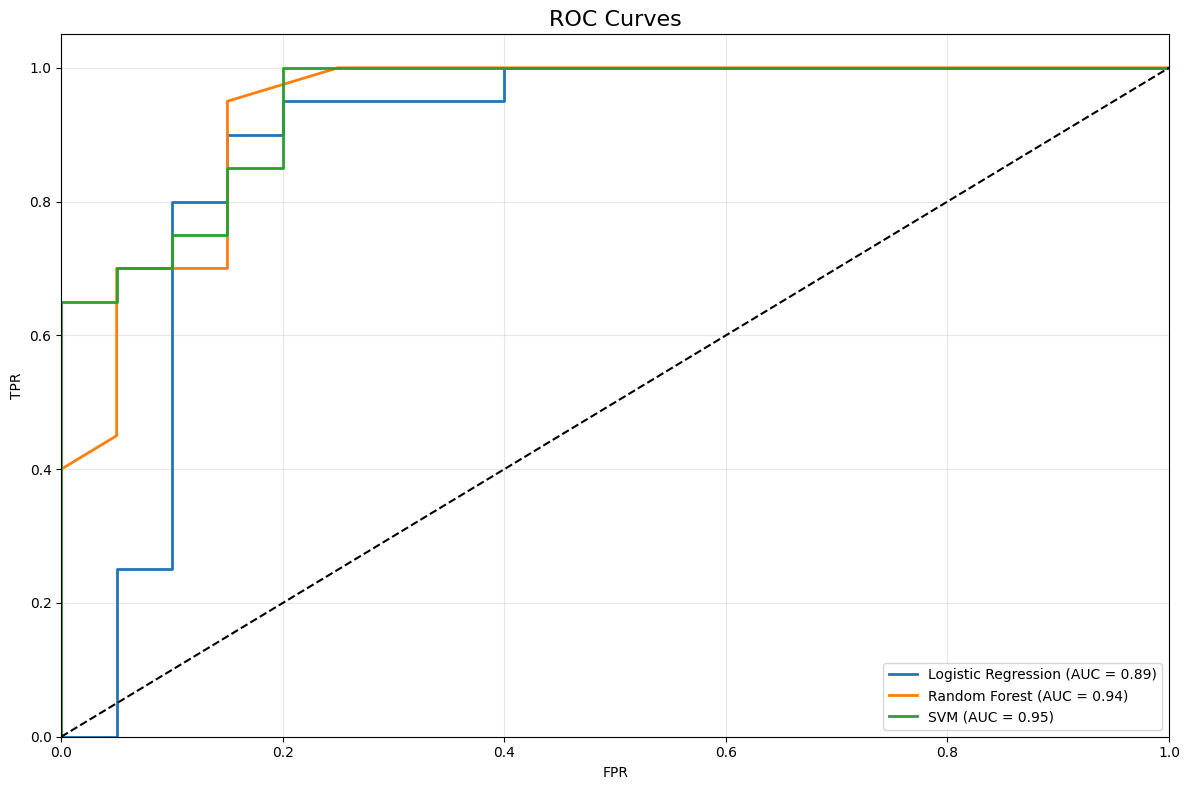

In [17]:
plt.figure(figsize=(12, 8))

for name in ['Logistic Regression', 'Random Forest', 'SVM']:
    if name in probabilities:
        fpr, tpr, _ = roc_curve(y_test, probabilities[name])
        auc_score = roc_auc_score(y_test, probabilities[name])
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# матрицы ошибок

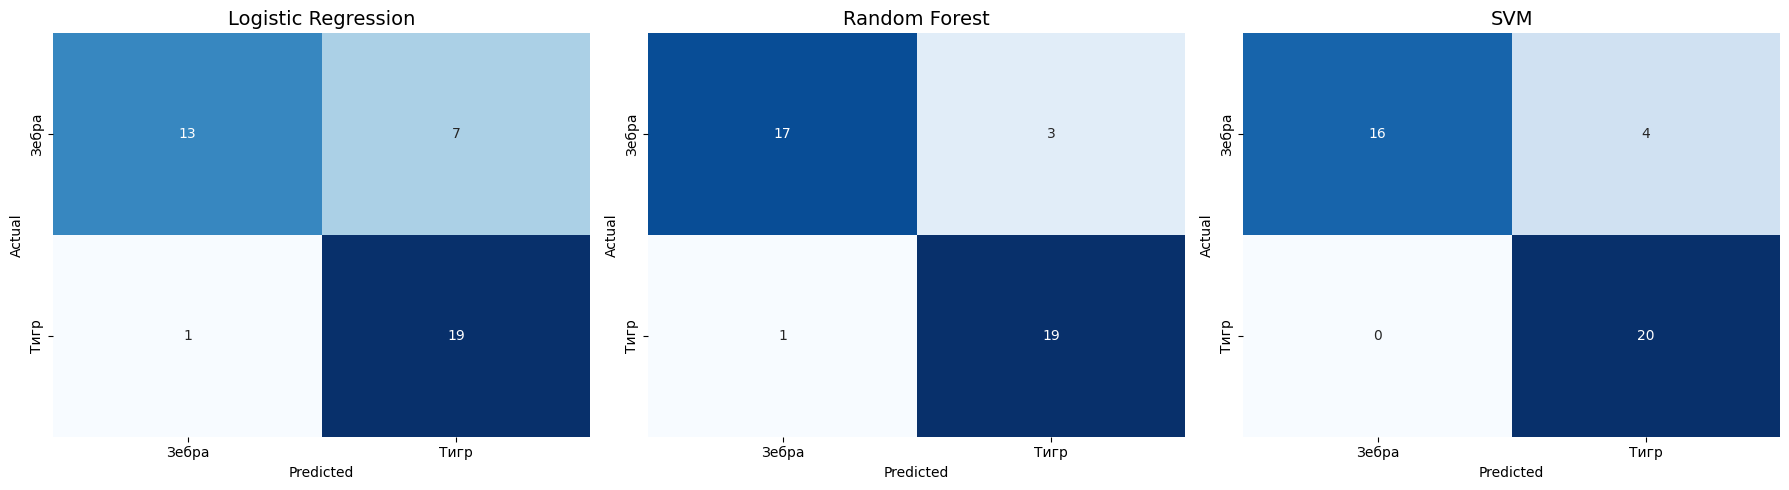

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(models):
    y_pred = predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar = False,
                xticklabels=['Зебра', 'Тигр'],
                yticklabels=['Зебра', 'Тигр'],
                ax=axes[idx])

    accuracy = accuracy_score(y_test, y_pred)
    axes[idx].set_title(f'{model_name}', fontsize=14)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ошибки LR

In [34]:
test_mask = df.index.isin(test_indices)
X_test_original = df.loc[test_mask].copy()

mask = y_pred_lr != y_test.values

misclassified_rows = X_test_original.loc[test_indices[mask], ['filename', 'label']].copy()
misclassified_rows['predicted'] = y_pred_lr[mask]

misclassified_rows = misclassified_rows.rename(columns={'label': 'Class'})
misclassified_rows['actual_class'] = misclassified_rows['Class']
misclassified_rows['predicted_class'] = misclassified_rows['predicted']

print("LR:")
print(misclassified_rows[['filename', 'actual_class', 'predicted_class']])

LR:
          filename  actual_class  predicted_class
27   tiger_083.jpg             1                0
114  zebra_071.jpg             0                1
184  zebra_028.jpg             0                1
120  zebra_061.jpg             0                1
160  zebra_037.jpg             0                1
102  zebra_099.jpg             0                1
151  zebra_035.jpg             0                1
121  zebra_068.jpg             0                1


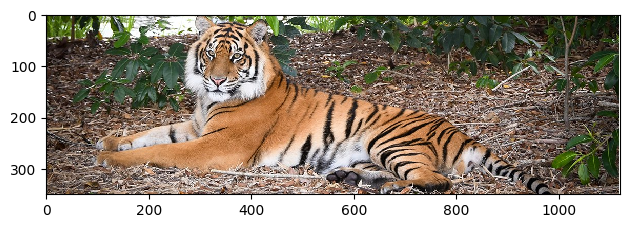

In [37]:
imshow(tiger_files[83])

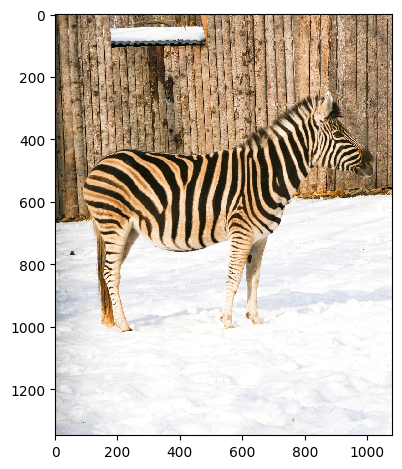

In [39]:
imshow(zebra_files[71])

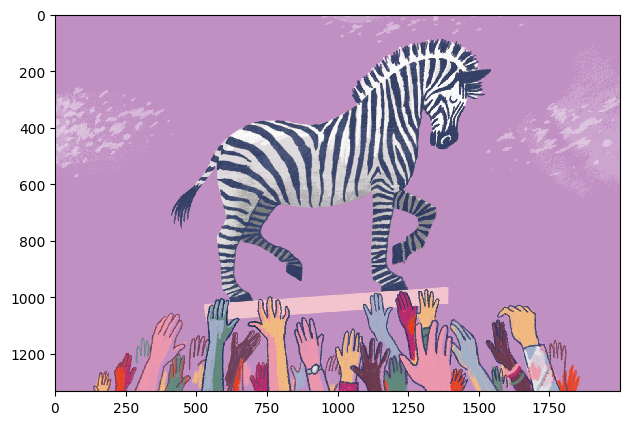

In [40]:
imshow(zebra_files[28])

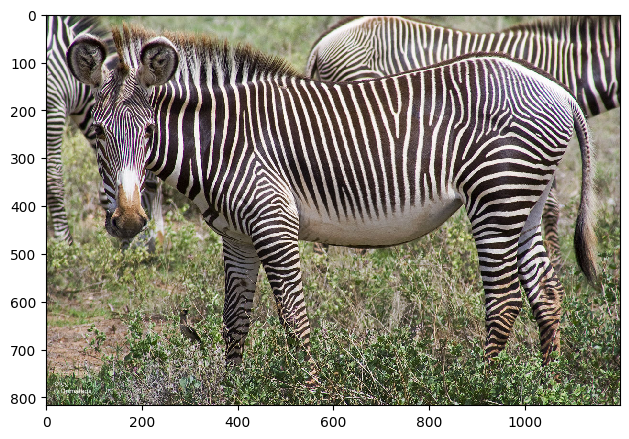

In [41]:
imshow(zebra_files[61])

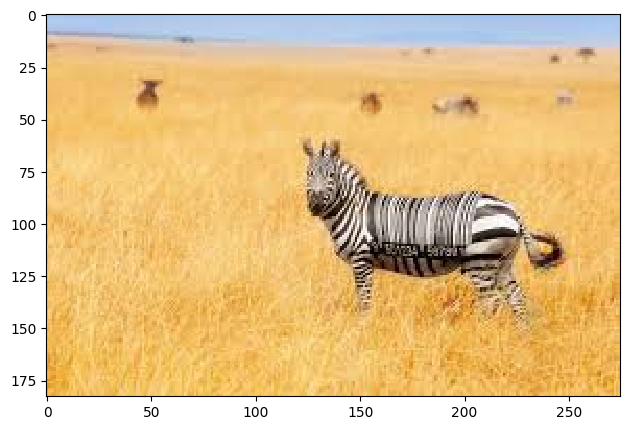

In [42]:
imshow(zebra_files[37])

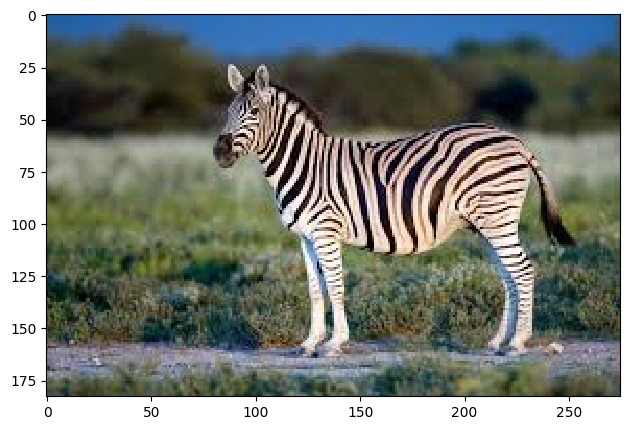

In [43]:
imshow(zebra_files[99])

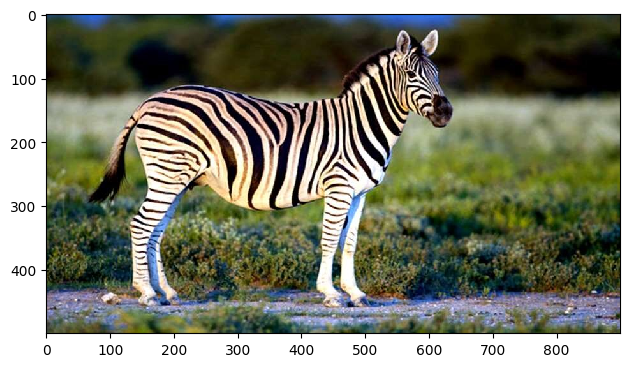

In [44]:
imshow(zebra_files[35])

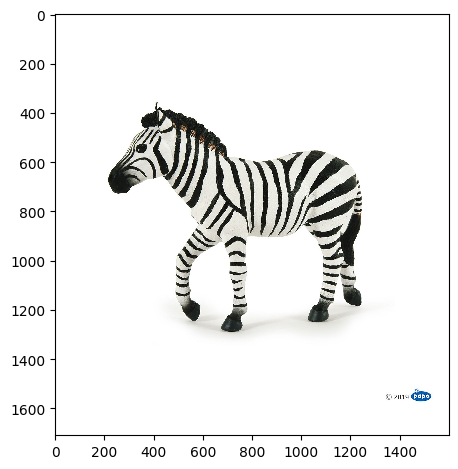

In [45]:
imshow(zebra_files[68])

# ошибки RF

In [35]:
mask = y_pred_rf != y_test.values

misclassified_rows = X_test_original.loc[test_indices[mask], ['filename', 'label']].copy()
misclassified_rows['predicted'] = y_pred_lr[mask]

misclassified_rows = misclassified_rows.rename(columns={'label': 'Class'})
misclassified_rows['actual_class'] = misclassified_rows['Class']
misclassified_rows['predicted_class'] = misclassified_rows['predicted']

print("RF:")
print(misclassified_rows[['filename', 'actual_class', 'predicted_class']])

RF:
          filename  actual_class  predicted_class
61   tiger_036.jpg             1                1
120  zebra_061.jpg             0                1
102  zebra_099.jpg             0                1
151  zebra_035.jpg             0                1


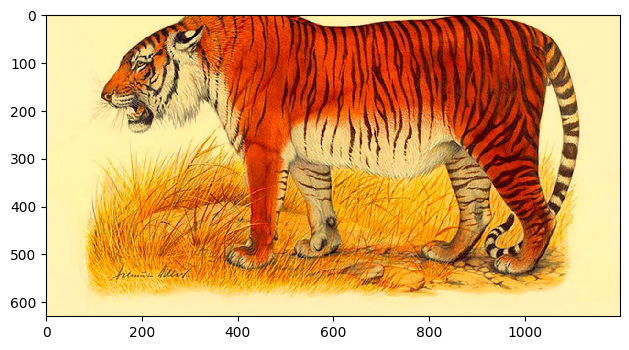

In [38]:
imshow(tiger_files[36])

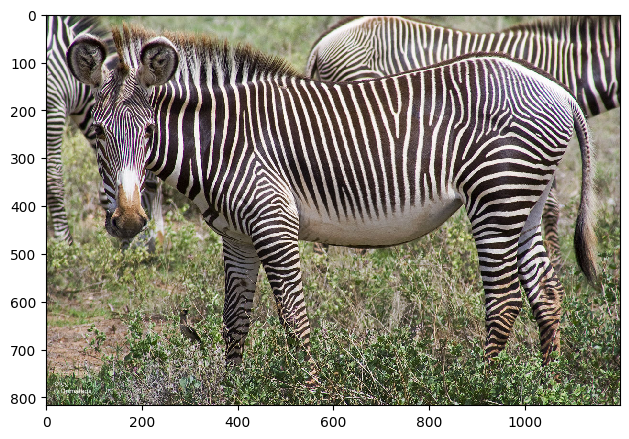

In [46]:
imshow(zebra_files[61])

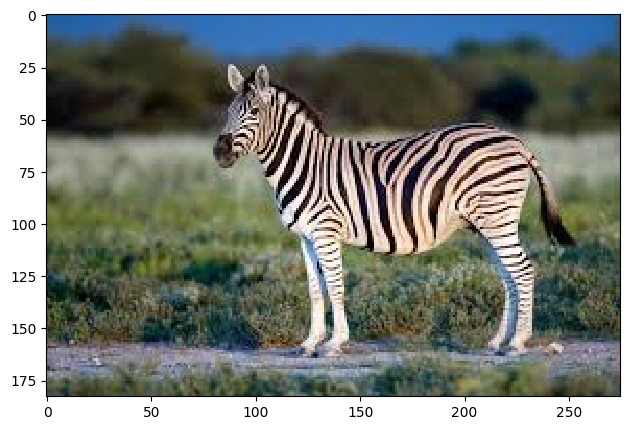

In [47]:
imshow(zebra_files[99])

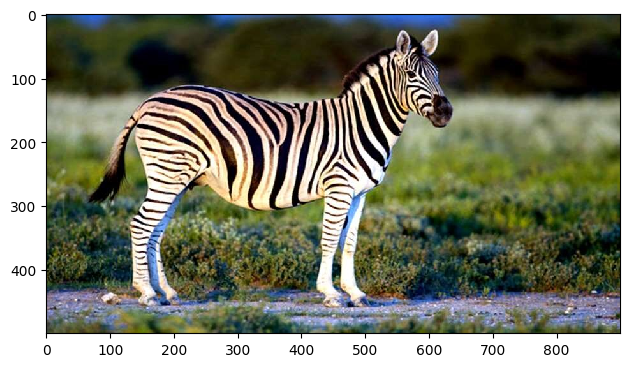

In [48]:
imshow(zebra_files[35])

# ошибки SVM

In [36]:
mask = y_pred_svm != y_test.values

misclassified_rows = X_test_original.loc[test_indices[mask], ['filename', 'label']].copy()
misclassified_rows['predicted'] = y_pred_lr[mask]

misclassified_rows = misclassified_rows.rename(columns={'label': 'Class'})
misclassified_rows['actual_class'] = misclassified_rows['Class']
misclassified_rows['predicted_class'] = misclassified_rows['predicted']

print("SVM:")
print(misclassified_rows[['filename', 'actual_class', 'predicted_class']])

SVM:
          filename  actual_class  predicted_class
120  zebra_061.jpg             0                1
160  zebra_037.jpg             0                1
102  zebra_099.jpg             0                1
151  zebra_035.jpg             0                1


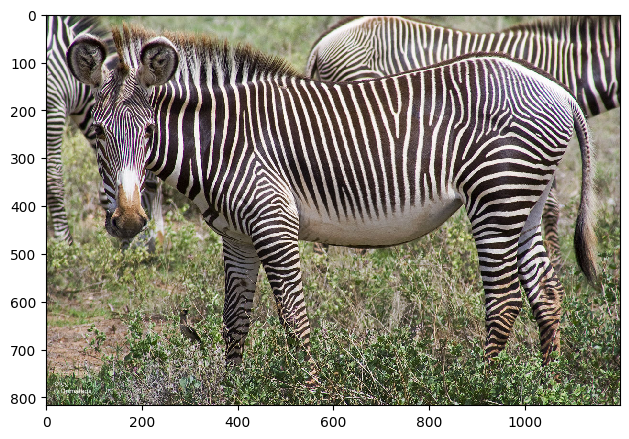

In [49]:
imshow(zebra_files[61])

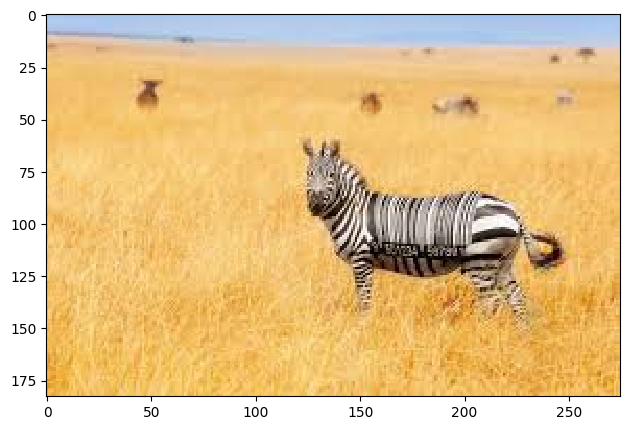

In [50]:
imshow(zebra_files[37])

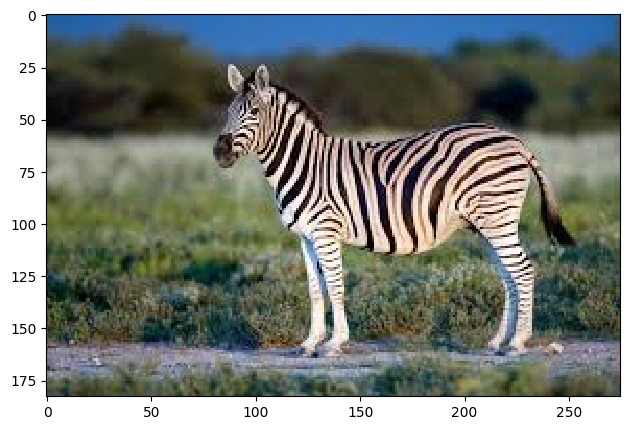

In [51]:
imshow(zebra_files[99])

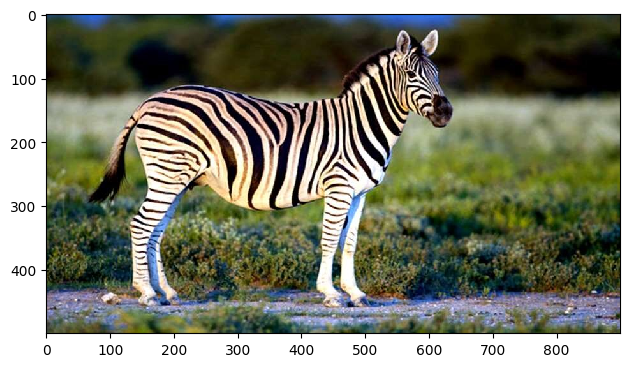

In [52]:
imshow(zebra_files[35])